In [1]:
from transformers import BertForSequenceClassification, BertForQuestionAnswering,\
    BertTokenizer, BertConfig
MODEL_CLASSES = {
    'bert-class': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'bert-qa': (BertConfig, BertForQuestionAnswering, BertTokenizer)
    # 'xlnet': (XLNetForSequenceClassification, XLNetTokenizer),
    # 'xlm': (XLMForSequenceClassification, XLMTokenizer),
}
label_offsets = {
    'ag_news_csv': -1,  # 1-4   # in our 33 labels: 0-3
    'amazon_review_full_csv': 3,  # 1-5    in our 33 labels: 4-8
    'yelp_review_full_csv': 3,  # 1-5   in our 33 labels: 4-8
    'dbpedia_csv': 8,  # 1-14  # in our 33 labels: 9-22
    'yahoo_answers_csv': 22  # 1-10  # in our 33 labels: 23-32
}

In [2]:
import pickle
import os
output_dir = "outputorder1_lr3e-5_sequential-sample_1adam_warmup"
args = pickle.load(open(os.path.join(output_dir, 'train_args'), 'rb'))


In [3]:
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert-qa']
tokenizer = tokenizer_class.from_pretrained(args.model_name)

In [4]:
def ids_to_sentence(seq):
    tmp = [tokenizer._convert_id_to_token(item) for item in seq[1:-1]]
    return " ".join(token for token in tmp if token not in ["[PAD]", "[SEP]"])

In [56]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
n_vis = 50
num_samples = 5

import sys


dataset_id = 0
adapt_lrs = [0.001, 0.005]
n_test = 200



for adapt_lr in adapt_lrs[:1]:
    accs_during_adapt = []
    num_matches = []
    num_mismatches = []

    for dataset_id in range(5):
        dataset_accs_during_adapt = []
        dataset_num_matches = []
        dataset_num_mismatches = []
        
        test_dataset = pickle.load(open(os.path.join(args.output_dir, 'test_dataset-{}'.format(dataset_id)), 'rb'))
        q_input_ids = pickle.load(open(os.path.join(args.output_dir, 'q_input_ids-{}'.format(dataset_id)), 'rb'))
        q_masks = pickle.load(open(os.path.join(args.output_dir, 'q_masks-{}'.format(dataset_id)), 'rb'))
        q_labels = pickle.load(open(os.path.join(args.output_dir, 'q_labels-{}'.format(dataset_id)), 'rb'))
        metrics = pickle.load(open(os.path.join(args.output_dir, 
                                                f"lr{adapt_lr}_metrics_against_adapt_step_{dataset_id}_ntest{n_test}"), "rb"))
        losses = metrics["loss"]
        accs= metrics["accuracy"]
        string = ""
        for idx in tqdm(range(n_test)):

            example_label, example_sequence = test_dataset[idx]
            example_sequence = ids_to_sentence(example_sequence)
            q_input_id, q_label = q_input_ids[idx], q_labels[idx]
            q_sequence = [ids_to_sentence(q) for q in q_input_id.numpy()]
            q_label = q_label.numpy()
            dataset_num_matches.append(np.mean(example_label == q_label))
            dataset_num_mismatches.append(np.mean(example_label != q_label))
            
            zipped_q_sequence = list(zip(q_label, q_sequence))
            np.random.shuffle(zipped_q_sequence)
            zipped_q_sequence = zipped_q_sequence
            string += f"Test example {idx}:\n"
            string += f"label: {example_label}\n"
            string += f"sequence: {example_sequence}\n\n"
#             if idx < n_test:
            string += f"adapt steps: {len(losses[idx])}\n"
            string += f"losses: {losses[idx]}\n"
            string += f"accs: {accs[idx]}\n\n"
            dataset_accs_during_adapt.append(accs[idx])
            string += "Retrieved examples:\n"

            for label, seq in zipped_q_sequence:
                string += f"label: {label}\n"
                string += f"sequence: {seq}\n"
            string += "\n\n"
        open(f"{output_dir}/lr{adapt_lr}_dataset{dataset_id}_retrieved_example_word_piece.txt", "w").write(string)
        accs_during_adapt.append(dataset_accs_during_adapt)
        num_matches.append(dataset_num_matches)
        num_mismatches.append(dataset_num_mismatches)
sys.stdout = sys.__stdout__

100%|██████████| 200/200 [00:00<00:00, 443.66it/s]


In [59]:
accs_during_adapt = np.array(accs_during_adapt)
num_matches = np.array(num_matches)
num_mismatches = np.array(num_mismatches)

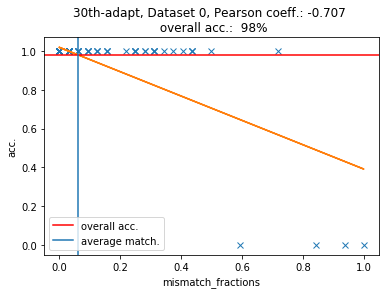

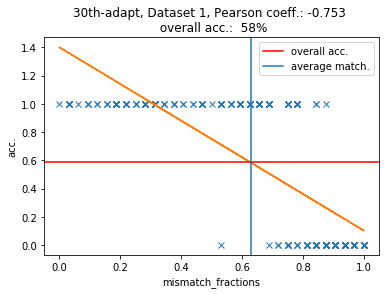

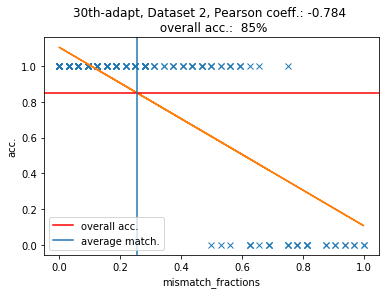

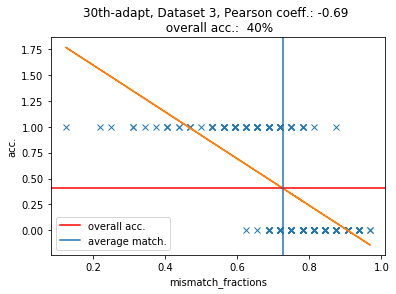

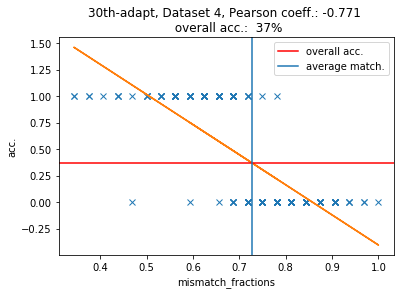

In [62]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.ticker import MaxNLocator
nth_adapt = 30
adapt_lr = 0.001
for i in range(len(accs_during_adapt)):
    match_fractions = num_mismatches[i]
    accs_fractions = accs_during_adapt[i, :, nth_adapt]
    m, b = np.polyfit(x=match_fractions, y=accs_fractions, deg=1)
    coeff, _ = pearsonr(match_fractions, accs_fractions)
#     mismatch_fractions = num_mismatches[i]
    plt.plot(match_fractions, accs_fractions, 'x')
    plt.plot(match_fractions, m * match_fractions + b)
    plt.axhline(y=np.mean(accs_fractions), color='r', linestyle='-', label="overall acc.")
    plt.axvline(x=np.mean(match_fractions), linestyle='-', label="average match.")
    plt.title(f"{nth_adapt}th-adapt, Dataset {i}, Pearson coeff.: {coeff: .3} \n overall acc.: {np.mean(accs_fractions): .0%}")
    plt.xlabel("mismatch_fractions")
    plt.ylabel("acc.")
    plt.legend()
    plt.savefig(f"{output_dir}/lr{adapt_lr:.0E}_acc_analysis(mismatch)_dataset{i}_ntest{n_test}_num-adapt{len(losses[idx]) - 1}")
    plt.show()


In [73]:
len(num_matches)

5

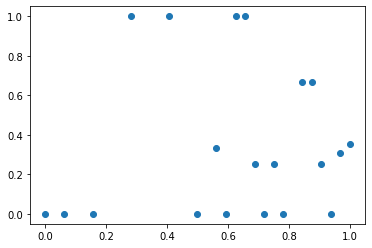

In [101]:
table = {}
for i, acc in enumerate(list(accs_during_adapt[-2, :, 5])):
    key = num_matches[0, i]
    if key not in table:
        table[key] = [0, 0]
    table[key][0] += acc
    table[key][1] += 1
t = {k: v[0]/v[1] for k, v in table.items()}
plt.plot(list(t.keys()), list(t.values()), "o")

In [102]:
table

{0.96875: [8, 26],
 1.0: [48, 136],
 0.9375: [0, 5],
 0.78125: [0, 1],
 0.65625: [1, 1],
 0.90625: [1, 4],
 0.75: [1, 4],
 0.875: [2, 3],
 0.28125: [1, 1],
 0.84375: [2, 3],
 0.5625: [1, 3],
 0.625: [1, 1],
 0.0625: [0, 1],
 0.6875: [1, 4],
 0.71875: [0, 2],
 0.40625: [1, 1],
 0.5: [0, 1],
 0.0: [0, 1],
 0.15625: [0, 1],
 0.59375: [0, 1]}

In [55]:
import numpy as np
from bokeh.layouts import row
from bokeh.models import ColumnDataSource, Slider, CustomJS
from bokeh.plotting import Figure, show

for dataset_id in range(5):
    # Define data
    match_fractions = num_matches[dataset_id]
    accs_fractions = accs_during_adapt[dataset_id, :, nth_adapt]
    x = num_matches[dataset_id]
    trigonometric_functions = {str(i): accs_during_adapt[dataset_id, :, i] for i in range(31)}
    initial_function = '0'

    # Wrap the data in two ColumnDataSources
    source_visible = ColumnDataSource(data=dict(
        x=x, y=trigonometric_functions[initial_function]))
    source_available = ColumnDataSource(data=trigonometric_functions)

    # Define plot elements
    plot = Figure(plot_width=400, plot_height=400)
    plot.scatter('x', 'y', source=source_visible)
    plot.scatter('x', 'y', source=source_visible, line_width=3, line_alpha=0.6)
    slider = Slider(title='Trigonometric function',
                    value=int(initial_function),
                    start=np.min([int(i) for i in trigonometric_functions.keys()]),
                    end=np.max([int(i) for i in trigonometric_functions.keys()]),
                    step=1)

    # Define CustomJS callback, which updates the plot based on selected function
    # by updating the source_visible ColumnDataSource.
    slider.callback = CustomJS(
        args=dict(source_visible=source_visible,
                  source_available=source_available), code="""
            var selected_function = cb_obj.value;
            // Get the data from the data sources
            var data_visible = source_visible.data;
            var data_available = source_available.data;
            // Change y-axis data according to the selected value
            data_visible.y = data_available[selected_function];
            // Update the plot
            source_visible.change.emit();
        """)

    layout = row(plot, slider)
    show(layout)

In [54]:
from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import figure


dataset_id = 4
# Define data
match_fractions = num_matches[dataset_id]
accs_fractions = accs_during_adapt[dataset_id, :, nth_adapt]
for i in range(31):
    'lons':[[-1.0, -1.1, -1.2, -1.3, -1.4], [-1.0, -1.1, -1.25, -1.35, -1.45]],
    'lats':[[53.0, 53.1, 53.2, 53.3, 53.4], [53.05, 53.15, 53.25, 53.35, 53.45]]
data_dict = {
    'lons':[[-1.0, -1.1, -1.2, -1.3, -1.4], [-1.0, -1.1, -1.25, -1.35, -1.45]],
    'lats':[[53.0, 53.1, 53.2, 53.3, 53.4], [53.05, 53.15, 53.25, 53.35, 53.45]]
}

full_source = ColumnDataSource(data_dict)
source = ColumnDataSource(data_dict)

p = figure(plot_width=400, plot_height=400, tools="")
p.multi_line(xs='lons', ys='lats', source=source)

callback = CustomJS(args = dict(source=source, full_source=full_source), code = """
    const time = cb_obj.value;
    const full_lons = full_source.data['lons']
    const full_lats = full_source.data['lats']

    for(i=0; i<full_lons.length; i++) {
        source.data['lons'][i] = full_lons[i].slice(0, time)
        source.data['lats'][i] = full_lats[i].slice(0, time)
    }
    // only need this because source.data is being updated "in place"
    source.change.emit()
    """)

slider = Slider(start = 0, end = 5, value = 0, step = 1, callback = callback)
slider.js_on_change('value', callback)
layout = column(p, slider)

show(layout)